In [1]:
# Import packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch.distributed as dist
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from collections import OrderedDict
from torchtext import vocab # This package can give problems sometimes, it may be necessary to downgrade to a specific version
import seaborn as sns
import random
from random import choice
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn import metrics
import os
import pickle
from transformers import AutoModelForMaskedLM, AutoTokenizer
import itertools
import copy
import warnings
import optuna
import logging
import sys
from torch_ema import ExponentialMovingAverage
import gc

# Metrics
from sklearn.metrics import recall_score
from scipy.stats import spearmanr, pearsonr


In [2]:
# Load CSV file into a DataFrame
merged_df = pd.read_csv('correlations.csv')
dpo_df = pd.read_csv('dpo_correlations.csv')[[
    'Sequence',
    'Ferruz_dpo_mutant_marginal_ESM2_score', 'Ferruz_dpo_ESM2_masked_marginal_score', # 'Ferruz_dpo_ESM2_pseudo_perplexity',
    'Hie_dpo_mutant_marginal_ESM2_score', 'Hie_dpo_ESM2_masked_marginal_score', # 'Hie_dpo_ESM2_pseudo_perplexity'
]]

# Merge the two DataFrames on 'Sequence'
merged_df = pd.merge(merged_df, dpo_df, on='Sequence', how='inner')

# (Optional) Save the merged DataFrame
merged_df.to_csv('merged_correlations.csv', index=False)

# Inspect the result
print("Merged columns:", merged_df.columns.tolist())
print(merged_df.head())
print(merged_df.columns)

Merged columns: ['Sequence', 'log_mean', 'Source', 'EnsMLP_Score', 'Conservative_EnsMLP_Score', 'fixed_vae_score', 'aligned_vae_score', 'fixed_ESM2_mutant_marginal_score', 'sft_ESM2_mutant_marginal_score', 'aligned_mutant_marginal_ESM2_score', 'fixed_ESM2_masked_marginal_score', 'sft_ESM2_masked_marginal_score', 'aligned_ESM2_masked_marginal_score', 'fixed_ESM2_pseudo_perplexity', 'sft_ESM2_pseudo_perplexity', 'aligned_ESM2_pseudo_perplexity', 'Ferruz_dpo_mutant_marginal_ESM2_score', 'Ferruz_dpo_ESM2_masked_marginal_score', 'Hie_dpo_mutant_marginal_ESM2_score', 'Hie_dpo_ESM2_masked_marginal_score']
                                            Sequence  log_mean  \
0  MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYTPDEVLGHNARFL...  4.178062   
1  MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYTPDEVLGHNARFL...  4.174245   
2  MAELDHSFVVADATLPDCPLVYASEGFYHMTGYGPDEVLGHNARFL...  4.171330   
3  MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.169668   
4  MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.167434  

In [3]:
merged_df.head()

,Sequence,log_mean,Source,EnsMLP_Score,Conservative_EnsMLP_Score,fixed_vae_score,aligned_vae_score,fixed_ESM2_mutant_marginal_score,sft_ESM2_mutant_marginal_score,aligned_mutant_marginal_ESM2_score,fixed_ESM2_masked_marginal_score,sft_ESM2_masked_marginal_score,aligned_ESM2_masked_marginal_score,fixed_ESM2_pseudo_perplexity,sft_ESM2_pseudo_perplexity,aligned_ESM2_pseudo_perplexity
0,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYTPDEVLGHNARFL...,4.178062,reward_model_test_df,4.116990,4.111576,-679.035584,-667.478638,-2.607955,13.290882,8.969199,-2.636312,14.087548,9.698018,-132.268234,-186.539780,-201.557617
1,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYTPDEVLGHNARFL...,4.174245,reward_model_test_df,4.143389,4.135478,-669.026123,-655.110413,3.224736,15.782164,11.316044,2.022076,15.834366,11.414676,-127.437439,-184.068024,-198.444046
2,MAELDHSFVVADATLPDCPLVYASEGFYHMTGYGPDEVLGHNARFL...,4.171330,reward_model_test_df,4.136582,4.126956,-51.544155,-47.281281,-1.940821,9.933219,5.973817,-3.578894,10.211020,6.323291,-134.535095,-188.093246,-202.107651
3,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.169668,reward_model_test_df,4.114146,4.107250,1.957041,11.110857,-4.509899,7.566288,4.299310,-3.330092,8.539899,5.214716,-137.138565,-191.249649,-204.702652
4,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.167434,reward_model_test_df,4.143983,4.136445,-111.645081,-103.950943,-9.110907,5.442672,1.646720,-9.114437,6.351361,2.494837,-141.613098,-193.657654,-207.448914


In [9]:
# Separate reward model test set and synthetic preference dataset from simulated annealing
test_df = merged_df[merged_df['Source'] == 'reward_model_test_df']
print('Length of dataset: ', len(test_df))


SFT_df = merged_df[merged_df['Source'] == 'SFT_df']
print('Length of dataset: ', len(SFT_df))


Length of dataset:  2401
Length of dataset:  86


In [10]:
def top_k_recall(true_scores, model_scores, percent_cutoff=10):
    ''' Adapted from
    https://github.com/OATML-Markslab/ProteinGym/blob/495cc305135767b53478dda1e12039c30d7f82ce/proteingym/performance_DMS_benchmarks.py#L72
    '''
    top_true = (true_scores >= np.percentile(true_scores, 100-percent_cutoff))
    top_model = (model_scores >= np.percentile(model_scores, 100-percent_cutoff))
    TP = (top_true) & (top_model)
    recall = TP.sum() / (top_true.sum())
    return recall


In [11]:
# List to hold correlation results
correlation_results = []

# DataFrames for correlation calculations
dataframes = {
    'reward_model_test_df': test_df,
    'SFT_df': SFT_df
}

# Columns to calculate correlations for
columns_with_metrics = [
    'EnsMLP_Score', 'Conservative_EnsMLP_Score',
    'fixed_vae_score', 'aligned_vae_score',
    'fixed_ESM2_mutant_marginal_score', 'sft_ESM2_mutant_marginal_score', 'aligned_mutant_marginal_ESM2_score', 'Ferruz_dpo_mutant_marginal_ESM2_score', 'Hie_dpo_mutant_marginal_ESM2_score',
    'fixed_ESM2_masked_marginal_score', 'sft_ESM2_masked_marginal_score', 'aligned_ESM2_masked_marginal_score', 'Ferruz_dpo_ESM2_masked_marginal_score', 'Hie_dpo_ESM2_masked_marginal_score',
    'fixed_ESM2_pseudo_perplexity', 'sft_ESM2_pseudo_perplexity', 'aligned_ESM2_pseudo_perplexity',] # 'Ferruz_dpo_ESM2_pseudo_perplexity', 'Hie_dpo_ESM2_pseudo_perplexity']

# Calculate Spearman correlations for each metric in each DataFrame
for df_name, df in dataframes.items():
    for metric in columns_with_metrics:
        if metric in df.columns:
            if df_name == 'reward_model_test_df':
                spearman_corr, p_value = spearmanr(df[metric], df['log_mean'])
                pearson_corr, _ = pearsonr(df[metric], df['log_mean'])
                accuracy = top_k_recall(df['log_mean'], df[metric], 10)
            else:
                spearman_corr, p_value = spearmanr(df[metric], df['EnsMLP_Score'])
                pearson_corr, _ = pearsonr(df[metric], df['EnsMLP_Score'])
                accuracy = top_k_recall(df['EnsMLP_Score'], df[metric], 10)
            
            # Append the results to the list
            correlation_results.append({
                'Source': df_name,
                'Metric': metric,
                'Spearman_Correlation': spearman_corr,
                'Pearson_Correlation': spearman_corr,
                'Top 10% Recall': accuracy
            })
        else:
            print(f"Column {metric} not found in {df_name} DataFrame.")

# Convert the list of results into a DataFrame
correlation_df = pd.DataFrame(correlation_results)
correlation_df


,Source,Metric,Spearman_Correlation,Pearson_Correlation,Top 10% Recall
0,reward_model_test_df,EnsMLP_Score,0.932622,0.932622,0.705394
1,reward_model_test_df,Conservative_EnsMLP_Score,0.933150,0.933150,0.705394
2,reward_model_test_df,fixed_vae_score,0.344451,0.344451,0.161826
3,reward_model_test_df,aligned_vae_score,0.345114,0.345114,0.170124
4,reward_model_test_df,fixed_ESM2_mutant_marginal_score,0.635565,0.635565,0.377593
5,reward_model_test_df,sft_ESM2_mutant_marginal_score,0.677200,0.677200,0.464730
6,reward_model_test_df,aligned_mutant_marginal_ESM2_score,0.634503,0.634503,0.427386
7,reward_model_test_df,Ferruz_dpo_mutant_marginal_ESM2_score,0.487602,0.487602,0.273859
8,reward_model_test_df,Hie_dpo_mutant_marginal_ESM2_score,0.072923,0.072923,0.087137
9,reward_model_test_df,fixed_ESM2_masked_marginal_score,0.724783,0.724783,0.394191


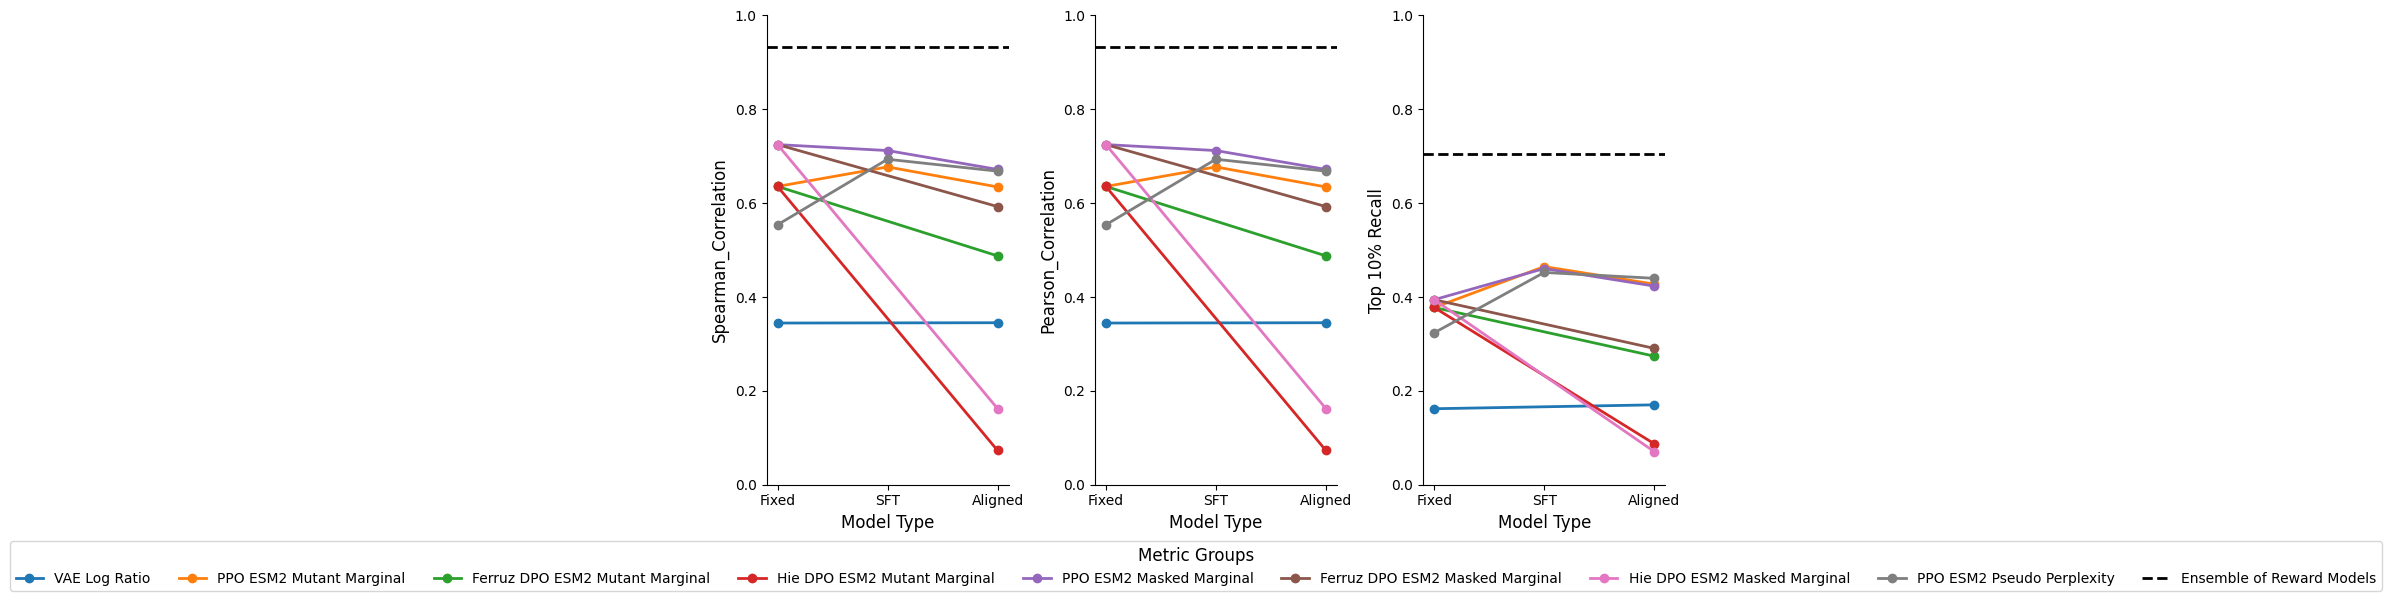

In [14]:
# Data
subset_df = correlation_df[correlation_df['Source'] == 'reward_model_test_df']

# x_positions dictionary
x_positions = {
    'fixed_vae_score': 0, 
    'aligned_vae_score': 2,
    
    'fixed_ESM2_mutant_marginal_score': 0, 
    'sft_ESM2_mutant_marginal_score': 1, 
    'aligned_mutant_marginal_ESM2_score': 2,
    'Ferruz_dpo_mutant_marginal_ESM2_score': 2,
    'Hie_dpo_mutant_marginal_ESM2_score': 2,
    
    'fixed_ESM2_masked_marginal_score': 0, 
    'sft_ESM2_masked_marginal_score': 1, 
    'aligned_ESM2_masked_marginal_score': 2,
    'Ferruz_dpo_ESM2_masked_marginal_score': 2,
    'Hie_dpo_ESM2_masked_marginal_score': 2,
    
    'fixed_ESM2_pseudo_perplexity': 0, 
    'sft_ESM2_pseudo_perplexity': 1, 
    'aligned_ESM2_pseudo_perplexity': 2,
    # 'Ferruz_dpo_ESM2_pseudo_perplexity': 2,
    # 'Hie_dpo_ESM2_pseudo_perplexity': 2,
    
}


# Define groups by how they were calculated
metric_groups = {
    'VAE Log Ratio': ['fixed_vae_score', 'aligned_vae_score'],
    
    'PPO ESM2 Mutant Marginal': ['fixed_ESM2_mutant_marginal_score', 'sft_ESM2_mutant_marginal_score', 'aligned_mutant_marginal_ESM2_score'],
    'Ferruz DPO ESM2 Mutant Marginal': ['fixed_ESM2_mutant_marginal_score', 'Ferruz_dpo_mutant_marginal_ESM2_score'],
    'Hie DPO ESM2 Mutant Marginal': ['fixed_ESM2_mutant_marginal_score', 'Hie_dpo_mutant_marginal_ESM2_score'],
    
    'PPO ESM2 Masked Marginal': ['fixed_ESM2_masked_marginal_score', 'sft_ESM2_masked_marginal_score', 'aligned_ESM2_masked_marginal_score'],
    'Ferruz DPO ESM2 Masked Marginal': ['fixed_ESM2_masked_marginal_score', 'Ferruz_dpo_ESM2_masked_marginal_score'],
    'Hie DPO ESM2 Masked Marginal': ['fixed_ESM2_masked_marginal_score', 'Hie_dpo_ESM2_masked_marginal_score'],
    
    'PPO ESM2 Pseudo Perplexity': ['fixed_ESM2_pseudo_perplexity', 'sft_ESM2_pseudo_perplexity', 'aligned_ESM2_pseudo_perplexity'],
    # 'Ferruz DPO ESM2 Pseudo Perplexity': ['fixed_ESM2_pseudo_perplexity', 'Ferruz_dpo_ESM2_pseudo_perplexity'],
    # 'Hie DPO ESM2 Pseudo Perplexity': ['fixed_ESM2_pseudo_perplexity', 'Hie_dpo_ESM2_pseudo_perplexity'],
}

# Correlation types to plot
correlations = ['Spearman_Correlation', 'Pearson_Correlation', 'Top 10% Recall']

# Create 3 subplots (one per correlation) in a single row
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharey=False)

for i, corr in enumerate(correlations):
    ax = axes[i]
    # Plot each metric group as a line on the current subplot
    for label, keys in metric_groups.items():
        xs = [x_positions[key] for key in keys]
        ys = [subset_df.loc[subset_df['Metric'] == key, corr].values[0] for key in keys]
        ax.plot(xs, ys, marker='o', label=label, linewidth=2)
    
    # Customize the x-axis
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Fixed', 'SFT', 'Aligned'])
    ax.set_xlabel('Model Type', fontsize=12)
    
    # Instead of a title, use the correlation as the y-axis label
    ax.set_ylabel(corr, fontsize=12)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 1)
    
    # Draw the baseline
    baseline_val = subset_df.loc[subset_df['Metric'] == 'EnsMLP_Score', corr].values[0]
    ax.axhline(baseline_val, color='black', linestyle='--', linewidth=2,
               label='Ensemble of Reward Models')

# Create one consolidated legend at the bottom of the figure.
# Collect legend handles and labels from the first axis
handles, labels = axes[0].get_legend_handles_labels()
# Remove duplicates if any
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='lower center',
           ncol=len(by_label), fontsize=10, title="Metric Groups", title_fontsize=12)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
plt.savefig('./figures/correlation_lineplots.svg')
plt.savefig('./figures/correlation_lineplots.png')
plt.show()